In [1]:
# author: René Kopeinig
# script: Trends and cycles in cryptocurrency data
# description: Applying Arima and stochastic cycle model to demonstrate 
#              the difference of trend from cycle on cryptocurrency data from Quandl

In [5]:
# Add IPython-specific directive to display plots directly below the notebook cell
%matplotlib inline

In [6]:
# Import dependencies
import os, quandl, pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [7]:
# Firstly: Get data from Quandl
# What is Quandl? It is a marketplace for financial, economic and alternative data 
# delivered in modern formats for today's analysts, including Python.

def get_data(quandl_id):
    '''Download and cache Quandl dataseries'''
    cache_path = '{}.pkl'.format(quandl_id).replace('/','-')
    print cache_path
    try:
        f = open(cache_path, 'rb')
        df = pickle.load(f)   
        print('Loaded {} from cache'.format(quandl_id))
    except (OSError, IOError) as e:
        print('Downloading {} from Quandl'.format(quandl_id))
        df = quandl.get(quandl_id, returns="pandas")
        df.to_pickle(cache_path)
        print('Cached {} at {}'.format(quandl_id, cache_path))
    return df

In [8]:
# Get Bitcoin Data
gdax_btc_eur = get_data('GDAX/EUR')
# Starting in June 2017 until September 2017
gdax_btc_eur = gdax_btc_eur['2017-06':'2017-09']

GDAX-EUR.pkl
Loaded GDAX/EUR from cache


In [9]:
hp_cycle, hp_trend = sm.tsa.filters.hpfilter(gdax_btc_eur['Open'], lamb=129600)

In [10]:
# Setting up Unobserved Components and ARIMA model
mod_uc_arima = sm.tsa.UnobservedComponents(gdax_btc_eur['Open'], 'rwalk', autoregressive=4)
res_uc_arima = mod_uc_arima.fit(method='powell', disp=False)
print(res_uc_arima.summary())

                        Unobserved Components Results                         
Dep. Variable:                   Open   No. Observations:                  119
Model:                    random walk   Log Likelihood                -747.551
                              + AR(4)   AIC                           1507.103
Date:                Sun, 01 Oct 2017   BIC                           1523.777
Time:                        13:57:59   HQIC                          1513.874
Sample:                    06-01-2017                                         
                         - 09-27-2017                                         
Covariance Type:                  opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
sigma2.level  1.199e+04   3472.899      3.454      0.001    5187.802    1.88e+04
sigma2.ar     3652.4924   2727.949      1.339 

In [11]:
# Setting up Unobserved components with stochastic cycle (UC)
mod_uc = sm.tsa.UnobservedComponents(gdax_btc_eur['Open'], 'rwalk',
                                     cycle=True, stochastic_cycle=True, damped_cycle=True)
res_uc = mod_uc.fit(method='powell', disp=False)
res_uc = mod_uc.fit(res_uc.params, disp=False)
print(res_uc.summary())

                            Unobserved Components Results                            
Dep. Variable:                          Open   No. Observations:                  119
Model:                           random walk   Log Likelihood                -736.733
                   + damped stochastic cycle   AIC                           1481.467
Date:                       Sun, 01 Oct 2017   BIC                           1492.583
Time:                               13:58:00   HQIC                          1485.981
Sample:                           06-01-2017                                         
                                - 09-27-2017                                         
Covariance Type:                         opg                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
sigma2.level     1.525e+04   2324.207      6.562      0.00

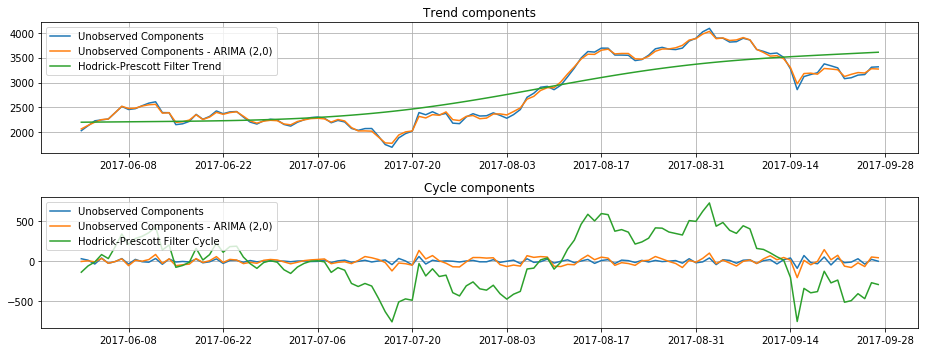

In [12]:
# Plot results
fig, axes = plt.subplots(2, figsize=(13,5));
axes[0].set(title='Trend components')
axes[0].plot(gdax_btc_eur.index, res_uc.level.smoothed, label='Unobserved Components')
axes[0].plot(gdax_btc_eur.index, res_uc_arima.level.smoothed, label='Unobserved Components - ARIMA (2,0)')
axes[0].plot(hp_trend, label='Hodrick-Prescott Filter Trend')
axes[0].legend(loc='upper left')
axes[0].grid()

axes[1].set(title='Cycle components')
axes[1].plot(gdax_btc_eur.index, res_uc.cycle.smoothed, label='Unobserved Components')
axes[1].plot(gdax_btc_eur.index, res_uc_arima.autoregressive.smoothed, label='Unobserved Components - ARIMA (2,0)')
axes[1].plot(hp_cycle, label='Hodrick-Prescott Filter Cycle')
axes[1].legend(loc='upper left')
axes[1].grid()

fig.tight_layout();